### Krill Growth Model (Atkinson et al 2006)

#### This empirical model derives a Daily Growth Rate (DGR, mm $d^{-1}$) from a starting length of an individual krill, chlorophyll concentration, and SST:

$DGR = a + b * Length + c * Length^2 + [d * \frac{CHL}{e + CHL}] + f * SST + g * SST ^2$

- Length (L mm) = Proxy for growth =  using 40mm as the starting value (observed mean length of adult krill)
- SST (°C) = Proxy for survival =  threshold between -1 to 5°C
- Chl-a (mg m$^{-3}$) = Proxy for food availability - threshold: 0.5 mg m-3

___
### Notebook Goal: 
#### write a function to calculate KGP in the same dimensions of an ensemble member:

example:

<code>def compute KGP(CHL, SST):
    return f(CHL) + g(SST)   
</code>
so that `KGP = compute_KGP(CHL, SST)` #inherits dims of chl and sst (member_id, time, nlat, nlon) and so that you can go further to do `KGP_SO = compute_areal_mean(KGP)` resulting in KGP_SO dims = m, t, region


In [47]:
#Import Modules
import os
import shutil

import cftime
from glob import glob
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
from math import exp
%matplotlib inline

In [48]:
#test conditions
length = 40
sst = 1
chl = 1

#DGR Expression
length_term = a + (b * length) + (c * length**2)
chl_term = d * (chl / e + chl)
sst_term = f * sst + g * sst**2
print('length term:', np.round(length_term, 3)) 
print('chl term:', np.round(chl_term, 3))
print('sst term:', np.round(sst_term, 3))

DGR = length_term + chl_term + sst_term
print('DGR Test Case:', np.round(DGR,2))

NameError: name 'a' is not defined

#### Theory of the Endgame Function:

In [50]:
#def compute_KGP(CHL, SST, start_len):
    ''' Calculates Mean Monthly Potential Growth from Chl-a and SST data
    Input: chl and sst arrays (with the same dimensions), starting length integer: 40 mm
    
    Process/Steps:
    1. generate a viable habitat array (vhab): using conditional masking 
        on the SST array, only include values within krill survival thresholds
    2. generate inrange_CHL array by masking the CHL array by the vhab array
    3. generate a viable growth habitat array (vgrow): using conditional masking 
        on the inrange_CHL array, only include values above krill growth requirement
    4. generate a init_len array: using 'xr.full_like' on the vgrow array, 
        filled with the start_len integer input: init_len = xr.full_like(vgrow, start_len)
    5. generate output array for the calculation results: DGR
    6. calculate DGR (mm d-1) from vhab, vgrow, and init_len
    7. calculate mean monthly potential growth (MPG in mm mon-1): DGR * no. of days in month
    8. return arrays: MPG, vhab, and vgrow
 
    Output: Returns the following arrays, all with the same dims as the input arrays:
        a) viable habitat range (vhab)
        b) viable growth habitat range (vgrow)
        c) mean monthly potential growth (MPG)
    
     ''';

IndentationError: unexpected indent (<ipython-input-50-cc5afac8711a>, line 2)

#### Read in an ensemble member from the CESM-LE

In [51]:
cesmle_root = '/glade/p/cesm/community/CESM-LE/data/CESM-CAM5-BGC-LE'

component = 'ocn'
freq = 'monthly'
stream = 'pop.h' # POP ocean model monthly stream
case = 'b.e11.B20TRC5CNBDRD.f09_g16.001'

variables = ['SST', 'diatChl', 'spChl', 'diazChl']
grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']

# loop over variables, construct list of datasets
ds_list = []
for v in variables:
    files = glob(f'{cesmle_root}/{component}/proc/tseries/{freq}/{v}/{case}.{stream}.{v}.*.nc')
    dsi = xr.open_mfdataset(files, decode_coords=False, decode_times=False, 
                            concat_dim='time',
                            combine='nested',
                            data_vars=[v],
                            chunks={'nlon': 16})
    # SST has a singleton z_t dimension, so remove this to avoid problems on merge
    if v == 'SST':
        dsi = dsi.squeeze(dim='z_t', drop=True).drop('dz')
        
        
    ds_list.append(dsi)
    
ds = xr.merge(ds_list)
ds = ds[variables+grid_vars]

ds['time'] = xr.DataArray(cftime.num2date(ds.time_bound.mean(dim='d2'), units=ds.time.units, 
                                         calendar=ds.time.calendar), dims=('time'))

ds['Chl_surf'] = (ds.diatChl + ds.spChl + ds.diazChl).isel(z_t_150m=0)
ds.Chl_surf.attrs = ds.diatChl.attrs
ds.Chl_surf.attrs['long_name'] = 'Surface chlorophyll'

variables = list(filter(lambda v: 'Chl' not in v, variables)) + ['Chl_surf']
ds = ds[variables+grid_vars]
ds

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1872, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1850-01-17 00:30:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<chunksize=(1872, 384, 16), meta=np.ndarray>
    Chl_surf    (time, nlat, nlon) float32 dask.array<chunksize=(1872, 384, 16), meta=np.ndarray>
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    dz          (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    time_bound  (time, d2) float64 dask.array<chunksize=(1872, 2), meta=np.ndarray>

### Reduce data set to a date range:

In [55]:
## Clip to 1920 - end:
ds_rec = ds[variables+grid_vars].isel(time=slice(839, 1872))
ds_rec

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1033, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1919-12-16 12:00:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<chunksize=(1033, 384, 16), meta=np.ndarray>
    Chl_surf    (time, nlat, nlon) float32 dask.array<chunksize=(1033, 384, 16), meta=np.ndarray>
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    dz          (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    time_bound  (time, d2) float64 dask.array<chunksize=(1033, 2), meta=np.ndarray>

In [56]:
### Reduce data set to Southern Ocean:

In [57]:
# Clip to Southern Ocean:
ds_so = ds_rec[variables+grid_vars].where((ds_rec.TLAT <= -45) & (ds_rec.KMT > 0))
ds_so

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1033, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1919-12-16 12:00:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<chunksize=(1033, 384, 16), meta=np.ndarray>
    Chl_surf    (time, nlat, nlon) float32 dask.array<chunksize=(1033, 384, 16), meta=np.ndarray>
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    dz          (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 16), meta=np.ndarray>
    time_bound  (time, d2, nlat, nlon) float64 dask.array<chunksize=(1033, 2, 384, 16), meta=np.ndarray>

#### Setting up the conditions for growth:

murphy: SST values <−1 °C were capped at −1 °C
devi: SST values <-1 °C were included, but a contour was drawn around the results as this is outside the bounds of uncertainty of the equation

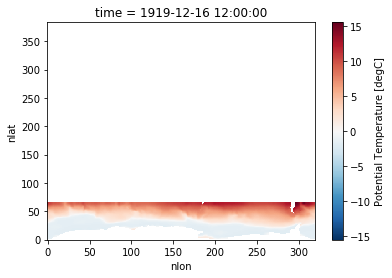

In [61]:
ds_so.SST.isel(time=0).plot()

In [62]:
#makes lists
feilds = ['SST', 'Chl_surf']
grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']

In [63]:
#makes array
conditions = (ds_so.SST >= -1) & (ds_so.SST <= 5) & (ds_so.Chl_surf >= 0.5)

In [64]:
#makes dataset
vgrowthhab = ds_so[feilds].where(conditions).fillna(0) 

In [65]:
#makes dataset of SST and Chl
final = ds_so[feilds].where(vgrowthhab)

In [66]:
final.SST.isel(time=0).plot()

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


KeyboardInterrupt: 

In [43]:
ds_so['SST']=final['SST']

In [16]:
def viable_growth_hab(dataset): #takes a dataset assuming it has all of the same things as inside
    feilds = ['SST', 'Chl_surf']
    #grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']

    conditions = (dataset.SST >= -1) & (dataset.SST <= 5) & (dataset.Chl_surf >= 0.5)
    vgrowthhab = dataset[feilds].where(conditions).fillna(0)
    
    #final = vgrowthhab[feilds] + dataset[grid_vars]
    
    final = dataset[variables+grid_vars]

    return vgrowthhab #final

In [17]:
VGH = viable_growth_hab(ds_so)
VGH

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320, time: 1033)
Coordinates:
  * time      (time) object 1919-12-16 12:00:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (time, nlat, nlon) float32 dask.array<chunksize=(1033, 384, 16), meta=np.ndarray>
    Chl_surf  (time, nlat, nlon) float32 dask.array<chunksize=(1033, 384, 16), meta=np.ndarray>

In [9]:
ds_so

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1033, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1919-12-16 12:00:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<chunksize=(1033, 384, 16), meta=np.ndarray>
    Chl_surf    (time, nlat, nlon) float32 dask.array<chunksize=(1033, 384, 16), meta=np.ndarray>
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    dz          (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 16), meta=np.ndarray>
    time_bound  (time, d2, nlat, nlon) float64 dask.array<chunksize=(1033, 2, 384, 16), meta=np.ndarray>

In [15]:
ds_drop = ds_so.drop_vars(ds_so.SST: Union[Hashable, Iterable[Hashable]], *, errors: str = 'raise') → 'Dataset'


KeyboardInterrupt: 

In [ ]:
grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']

ds_viable = VGH[variables+grid_vars]


In [ ]:
new_ds_so = xr.merge(VGH, )

In [10]:
VGH = viable_growth_hab(ds_rec.SST, ds_rec.Chl_surf, ds_rec)
VGH

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1033, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1919-12-16 12:00:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<chunksize=(1033, 384, 16), meta=np.ndarray>
    Chl_surf    (time, nlat, nlon) float32 dask.array<chunksize=(1033, 384, 16), meta=np.ndarray>
    KMT         (nlat, nlon, time) float64 dask.array<chunksize=(384, 16, 1033), meta=np.ndarray>
    TAREA       (nlat, nlon, time) float64 dask.array<chunksize=(384, 16, 1033), meta=np.ndarray>
    TLAT        (nlat, nlon, time) float64 dask.array<chunksize=(384, 16, 1033), meta=np.ndarray>
    TLONG       (nlat, nlon, time) float64 dask.array<chunksize=(384, 16, 1033), meta=np.ndarray>
    dz          (z_t, time, nlat, nlon) float32 dask.array<chunksize=(60, 1033, 384, 16), meta=np.ndarray>
    time_bound  (time, d2, nlat, nlon) float64 dask.array<chunksize=(1033, 2, 384, 16), meta=np.ndarray>

In [11]:
VGH.SST.isel(time=0).plot(vmin=-2, vmax=10)

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


KeyboardInterrupt: 

In [ ]:
# Step 1: xarray.where(cond, x, y)
# cond (scalar, array, Variable, DataArray or Dataset with boolean dtype) – When True, return values from x, otherwise returns values from y.
# y (x,) – Values from which to choose. All dimension coordinates on these objects must be aligned with each other and with cond.

vhab = SST.where()

In [ ]:
## from other notebooks / convos

southernocean = ds.TAREA.where((ds.TLAT <= -45) & (ds.KMT > 0))

conditions = (ds.sst >= -1) & (ds.sst <= 5) & (ds.chl >= 0.5)
ds = ds.where(conditions).fillna(0).where(southernocean=True) #set 'ocean' as a mask earlier


In [ ]:
# from matt explaining the krill function:

chl_term = ((d * ds.chl) / (e + ds.chl)) # time, lat, lon
sst_term =  (f * ds.sst) + (g * ds.sst**2) # time, lat, lon

for i, L_i in enumerate(my_array_of_L_i_values):
    len_term = a + (b * L_i) + (c * L_i**2)  
    kgp[i, ...] = len_term + chl_term + sst_term